## 📊 Step 1: Load and Preprocess the Iris Dataset

We will use the classic **Iris dataset**, which consists of 150 samples from 3 species of iris flowers. Each sample has 4 features:

- sepal length
- sepal width
- petal length
- petal width

We'll perform the following steps:

1. Load the data using `sklearn.datasets`
2. Standardize the feature values (important for neural networks)
3. Split into training and test sets
4. Convert everything to **PyTorch tensors** so the model can train on GPU or CPU


In [13]:
# !pip install torch torchvision torchaudio

In [5]:
# 📦 Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [6]:
# Load the Iris dataset
iris = load_iris()
X = iris.data        # Feature matrix (shape: [150, 4])
y = iris.target      # Labels (0 = Setosa, 1 = Versicolor, 2 = Virginica)

# Standardize features (zero mean, unit variance)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Convert numpy arrays to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)


## 🧠 Step 2: Define the ANN Model Architecture

We’ll create a simple feedforward neural network (Multi-Layer Perceptron) with:
- Input layer (4 features)
- 1 hidden layer with ReLU activation
- Output layer with 3 neurons (one per class)

We'll use `CrossEntropyLoss`, so the output layer **should not** include Softmax explicitly — PyTorch handles it internally.


In [7]:
# Define the MLP model
class IrisANN(nn.Module):
    def __init__(self):
        super(IrisANN, self).__init__()
        self.fc1 = nn.Linear(4, 16)   # input layer → hidden
        self.fc2 = nn.Linear(16, 3)  # hidden layer → output layer (3 classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))     # activation on hidden layer
        x = self.fc2(x)             # output logits
        return x

# Instantiate the model and move to device (CPU or GPU)
model = IrisANN().to(device)
print(model)


IrisANN(
  (fc1): Linear(in_features=4, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=3, bias=True)
)


## 🏋️ Step 3: Set Loss Function, Optimizer, and Train

We'll train the model using:
- **CrossEntropyLoss** (for multi-class classification)
- **Adam optimizer** (for faster convergence)
- Accuracy tracking for evaluation


In [8]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()                     # for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.01)   # Adam optimizer

# Training loop
epochs = 100
train_losses = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()               # clear gradients
    outputs = model(X_train)            # forward pass
    loss = criterion(outputs, y_train)  # compute loss
    loss.backward()                     # backpropagation
    optimizer.step()                    # update weights
    
    train_losses.append(loss.item())    # record loss
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")


Epoch 10/100, Loss: 0.6767
Epoch 20/100, Loss: 0.4634
Epoch 30/100, Loss: 0.3375
Epoch 40/100, Loss: 0.2510
Epoch 50/100, Loss: 0.1794
Epoch 60/100, Loss: 0.1260
Epoch 70/100, Loss: 0.0957
Epoch 80/100, Loss: 0.0786
Epoch 90/100, Loss: 0.0689
Epoch 100/100, Loss: 0.0631


## 📈 Step 4: Evaluate the Model & Plot Training Loss

We check the model's classification accuracy on the test set and plot the training loss curve.


In [9]:
# Evaluate accuracy on test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    predictions = torch.argmax(test_outputs, dim=1)
    accuracy = (predictions == y_test).float().mean()
    print(f"Test Accuracy: {accuracy.item() * 100:.2f}%")


Test Accuracy: 100.00%


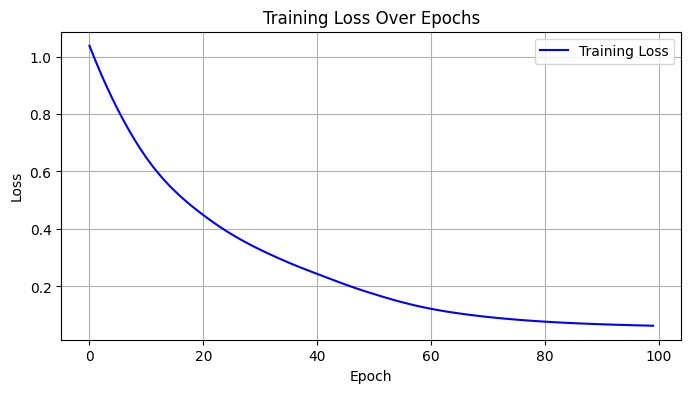

In [10]:
# Plot training loss
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()


## 🧩 Step 5: Visualize Confusion Matrix

A **confusion matrix** helps us understand how well the classifier is performing across each class.


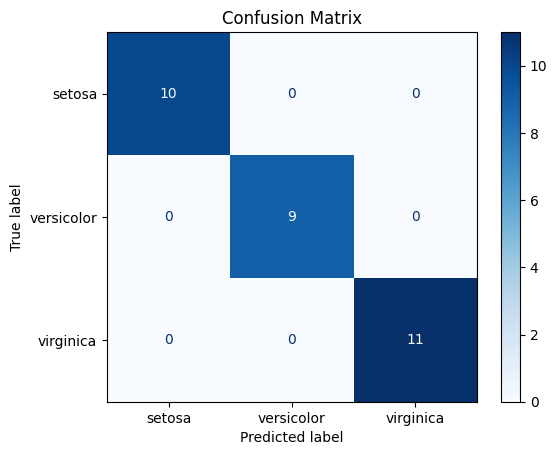

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Move predictions and labels to CPU for sklearn compatibility
y_true = y_test.cpu().numpy()
y_pred = predictions.cpu().numpy()

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display confusion matrix with class labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=iris.target_names)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


## 🔎 Step 6: Perform Inference with the Trained Model

We now use the trained model to predict the class of a **new sample** (manually selected from the test set).


In [12]:
# Inference on a single test example
sample_idx = 3  # change index to test another sample
sample = X_test[sample_idx].unsqueeze(0)  # add batch dimension (1, 4)

model.eval()
with torch.no_grad():
    logits = model(sample)
    predicted_class = torch.argmax(logits, dim=1).item()

    print(f"Predicted class: {iris.target_names[predicted_class]}")
    print(f"Actual class: {iris.target_names[y_test[sample_idx].item()]}")


Predicted class: versicolor
Actual class: versicolor


## ✅ Conclusion: ANN/MLP on Iris Dataset

In this notebook, we built and trained a **Multi-Layer Perceptron (MLP)** to classify iris flowers using PyTorch.

### 🔍 What we accomplished:
- Loaded and preprocessed the Iris dataset
- Built a simple ANN model with 1 hidden layer
- Trained it using CrossEntropyLoss and Adam optimizer
- Evaluated performance using accuracy and confusion matrix
- Performed inference on individual samples
